# NYPD Fare Evasion Enforcement's Disparate Impact
Leena Kahlon, Dylan Fosgett, Woo Hyuk Chang and Rebecca Dorn
University of California, Santa Cruz, Fall 2019

<img src="https://pbs.twimg.com/media/EJAwu4gWsAoPKwL?format=jpg&name=medium">

*Image from Twitter's @DecolonizeThisPlace*

## Introduction
***
Imagine your loan application has just been rejected by your bank. You ask them why, and they respond that the neighborhood you live in scored poorly for likelihood to pay the loan back. For some reason this bank has the algorithm they use online. You look into it a bit more, and you realize that though the bank does not use race as a feature, those who live in predominantly African American neighborhoods are almost three times as likely to be denied a loan. Disparate impact refers to "when policies, practices, rules or other systems that appear to be neutral result in a disproportionate impact on a protected group". No one in the bank sat down and say "hey, I'm going to create a fairly racist predictor!". But, the rules that the bank goes by dispraportionately impact African Americans. Situations like these are all too common in the United States, and they must be addressed.

On October 28, 2019, a video of around ten police officers tackling and pulling guns on a black teen for evading the \$2.75 subway fare in New York City went viral. Communities were enraged to see this fierceley violent attack on a teen of color over such a small fare. A few months before, the MTA calculated that they were losing millions annually due to those who evade paying the transit fare. The MTA decided to deploy 500 new officers to watch for turnstile hoppers, in hopes of losing less money. While in theory this plan makes sense, we can't help but wonder. What kind of disparate impact against communities of color is happening? What about against lower income communities?


## Setup: Installing Necessary Libraries
```pip install matplotlib
pip install numpy
pip install pandas
pip install geopandas
pip install beautifulsoup4
pip install seaborn
pip install twitter
pip install nltk```

Cooresponding files can be found on git: https://github.com/rebdorn/fare_evasion

## Project
***
We organize our project into distinct portions
1. Web Scraping
2. Data Wrangling
3. Data Visualization

Our goal is to create an easy-to-use visualization to answer the following research questions:
1. How has fare evasion enforcement in New York City changed in recent years?
2. What subway stations have an outstanding number of recent police sightings? What are the demographics around these stations?
3. What are the fare evasione enforcement trends around stations with outstanding numbers of recent police sightings?
4. What is the overlap between stations with more police sightings and stations with more fare evasion enforcement?

# Web Scraping
***
To get recent police sightings, we scrape twitter account @unfarenyc. This is an account where people send information about police sightings at subway stations, and they post the number of cops and which subway station. We scrape the twitter account these sightings using nltk and bear's python twitter wrapper. Note that to run this code on your account, you must posess a secret key given by the Twitter API.

We begin by running some import statements. Make sure to run this cell, or else the code won't work!

In [1]:
# Some import statements to make our code run
from itertools import permutations
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import twitter
import nltk

**Scraping the Twitter API:** We use bare's Python wrapper for the twitter API to make our life easier. The operations we do occur as follows:
- Connect to the Twitter API using our given keys. (Note: a key is not provided in this demo, make sure to plug your own key into git.ignore before running thic cell!)
- Get the entirety of @UnfareNYC's timeline. The function "GetUserTimeine" requires we specify the number of tweets to request, and the maximum is 200. Because of this, we need to recursively find the earliest tweet out of the 200 we get, and use that as an end point for the 200 tweets beforehand.
- The twitter API gives us a hefty amount of information. So, store only our most desired information in our dataframe: ID, User, created_at and text.

In [2]:
CONSUMER_KEY = '0ift2jAgEYQrWs8OP1f9TjRQ1'
CONSUMER_SECRET = 'qq9jNTaS3cG9wVc2Hxij3M0GuhAy72wNzFnBc9y1ejp2xh5dg4'
ACCESS_TOKEN_KEY = '144353594-pUtB5UxLeZHwZxJH4vPtFQMXAvgyQKTyvDanafog'
ACCESS_TOKEN_SECRET = 'TvGH6dRf2J0PTKgBiSwWJ022j25PNBBaYUZQYWML1bDok'

# connect to twitter API with our given user credentials
api = twitter.Api(consumer_key = CONSUMER_KEY,
                      consumer_secret = CONSUMER_SECRET,
                      access_token_key = ACCESS_TOKEN_KEY,
                      access_token_secret = ACCESS_TOKEN_SECRET)

In [22]:
# Scrape @unfarenyc's twitter timeline
statuses_list = api.GetUserTimeline(count=200,screen_name='unfarenyc') # Load @unfarenyc's timeline

# To get earlier tweets we continuously find the minimum and get the 200 previous
earliest_tweet = min(statuses_list, key=lambda x: x.id).id # Find the last tweet we were allowed to get
while True: # While there are more tweet to get
    nexttweets = api.GetUserTimeline(screen_name='unfarenyc', max_id=earliest_tweet, count=200)
    new_earliest = min(nexttweets, key=lambda x: x.id).id
    if not nexttweets or new_earliest == earliest_tweet:
        break
    else:
        earliest_tweet = new_earliest
        statuses_list += nexttweets

In [23]:
# Store the desired information into a dataframe
tweets = []
for s in statuses_list:
    tweets.append([s.id,s.user.screen_name,s.created_at,s.text,s.retweet_count])
tweetsdf = pd.DataFrame(tweets,columns=['ID','user','created_at','text','retweets'])

We define two functions. One to process subway station names such that they are all lowercase, we separate "2nd" to "2" and "nd" (Same with formats of 1st, 17th) and change some common phrases to be short and don't include vowels. Secoond function is to change unigrams to match station names-- we remove some specific punctuation and change park -> pk, etc.

In [24]:
# Our NLP protocol for getting unigrams into a usable form
def process_unigram(unigram):
    if unigram[0].isdigit() & unigram.endswith('st'): # Are we of form "1"st?
        unigram = unigram[:-2] # Shorten unigram to only that street number
    elif unigram[0].isdigit() & unigram.endswith('nd'): # Are we of form "2"nd?
        unigram = unigram[:-2] # Shorten unigram to just that number
    elif unigram[0].isdigit() and unigram.endswith('th'): # Are we of form "10"th?
        unigram = unigram[:-2] # Shorten unigram to only that number
    elif unigram[0].isdigit() and unigram.endswith('rd'): # Are we of form "10"th?
        unigram = unigram[:-2] # Shorten unigram to only that number
    elif unigram == 'park': # If this unigram reads 'park'
        unigram = 'pk' # Shorten it to match our station names
    elif unigram == 'parkway': # If this unigram reads "parkway"
        unigram = 'pkwy' # Shorten it to match our station names
    elif unigram == 'heights': # If this unigram reads "heights"
        unigram = 'hts' # Shorted it to match our station names
    return unigram

# Our NLP protocol for processing subway names (removing punct, etc.)
def process_stations(df_col):
    processed_tweets = df_col.str.replace(" - "," ")
    processed_tweets = processed_tweets.str.replace("-"," ")
    processed_tweets = processed_tweets.str.replace("/"," ")
    processed_tweets = processed_tweets.str.replace(".","")
    processed_tweets = processed_tweets.str.replace("'","")
    processed_tweets = processed_tweets.str.lower()
    processed_tweets = processed_tweets.str.replace("ave","av")
    processed_tweets = processed_tweets.str.replace("street","st")
    processed_tweets = processed_tweets.str.replace("square","sq")
    processed_tweets = processed_tweets.str.replace("heights","hts")
    processed_tweets = processed_tweets.str.replace("park","pk")
    processed_tweets = processed_tweets.str.replace("jay st metrotech","jay st")
    return processed_tweets

Process the subway names, create a list of subway station names to later check tweets

In [25]:
# Read the CSV file of Subway Station names and process the names
stations = pd.read_csv("Stations.csv")

# Process the station names, convert to list for easy searching
station_names = list(process_stations(stations['Stop Name']))

# Process the tweets such that it sepearates hyphens, we process unigrams more later.
processed_tweets = process_stations(tweetsdf['text'])

# Add new empty column to tweetsdf to store station names
tweetsdf['station_referral'] = np.nan

Create column of datetime objects

In [26]:
from datetime import date

# A simple mapping of the first 3 letters of months to their numerical representation
month_number = { 'Jan' : 1, 'Feb' : 2, 'Mar' : 3, 'Apr' : 4,
                'May': 5, 'Jun' : 6, 'Jul' : 7, 'Aug' : 8,
                'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12}

# Create a new column in the tweets dataframe for our datetime objects and populate
tweetsdf['created_at_datetime'] = np.nan
for k, instance in enumerate(tweetsdf['created_at']): # for each tweet's creation time/day
    for i, chunk in enumerate(instance.split(" ")): # parse through the datetime, split by space
        if i == 1:
            this_month = month_number[chunk]
        elif i == 2:
            this_day = int(chunk)
        elif i == 5:
            this_year = int(chunk)
    tweet_datetime = date(year = this_year, month = this_month, day = this_day)
    tweetsdf.loc[k,'created_at_datetime'] = tweet_datetime

Loop through tweets, check fourgram -> unigram if this is a station name (Bigger name first helps ensure we get right station)

In [27]:
# Loop through each tokened tweet and look for the subway station

for i, row in enumerate(processed_tweets.apply(nltk.tokenize.word_tokenize)):
    found = 0 # At the beginning of each tweet, reset bool found
    
    for fourgram in nltk.ngrams(row,4): # Check each combo of 4 tokens in tweet
        for unigram in fourgram: # Process the individual unigrams in the fourgram
            unigram = process_unigram(unigram)
        one, two, three, four = fourgram # Unpack fourgram to permute versions of tuple
        for ordering in permutations([one, two, three, four]): # For each possible ordering of these unigrams
            perm_one, perm_two, perm_three, perm_four = ordering # Unpack this permutation
            if perm_one+" "+perm_two+" "+perm_three+" "+perm_four in station_names[:]: # If this permutation is a station name
                tweetsdf.loc[i,'station_referral'] = perm_one+" "+perm_two+" "+perm_three+" "+perm_four # Put the data in our dataframe
                found = 1 # Signal that for this tweet we have found the station
                break # Break out of the loop!
    
    if found != 1: # If we have checked all fourgrams and did not find the subway station
        for trigram in nltk.trigrams(row):
            for unigram in trigram:
                unigram = process_unigram(unigram)
            one, two, three = trigram
            for ordering in permutations([one, two, three]):
                perm_one, perm_two, perm_three = ordering
                if perm_one+" "+perm_two+" "+perm_three in station_names[:]:
                    tweetsdf.loc[i,'station_referral'] = perm_one+" "+perm_two+" "+perm_three
                    found = 1
                    break
    if found != 1:
        for bigram in nltk.bigrams(row):
            for unigram in bigram:
                unigram = process_unigram(unigram)
            one, two = bigram
            for ordering in permutations([one, two]):
                perm_one, perm_two = ordering
                if perm_one+" "+perm_two in station_names[:]:
                    tweetsdf.loc[i,'station_referral'] = perm_one+" "+perm_two
                    found = 1
                    break         
    if found != 1:
        for unigram in row:
            unigram = process_unigram(unigram)
            if unigram+" st" in station_names[:]:
                tweetsdf.loc[i,'station_referral'] = unigram+" st"
                found = 1
                break
            elif unigram+" av" in station_names[:]:
                tweetsdf.loc[i,'station_referral'] = unigram+" av"
                found = 1
                break
            elif unigram in station_names[:]:
                tweetsdf.loc[i,'station_referral'] = unigram
                found = 1
                break

by hand: list all stations in on jurisdiction (transit_district_30 = []) etc.
plot them and then tell the users of this notebook that they are welcome to try it out for the other transit districts.


In [28]:
# Here goes code for mapping out top stations in some transit district

# Create bins for tweets of the tweek
weeklyRanges = np.nan
print(tweetsdf['created_at_datetime'])

tweetsdf
# Get average sightings per week

0       2019-12-01
1       2019-12-01
2       2019-12-01
3       2019-12-01
4       2019-12-01
           ...    
2008    2019-08-12
2009    2019-08-10
2010    2019-08-09
2011    2019-08-09
2012    2019-08-09
Name: created_at_datetime, Length: 2013, dtype: object


,ID,user,created_at,text,retweets,station_referral,created_at_datetime
0,1201208571024871424,unfarenyc,Sun Dec 01 18:36:55 +0000 2019,2 cops in uniform on the Manhattan bound Dekal...,0,2 av,2019-12-01
1,1201188382149349379,unfarenyc,Sun Dec 01 17:16:41 +0000 2019,47th-50th St Rockefeller Center - two uniforme...,0,50 st,2019-12-01
2,1201152450083872769,unfarenyc,Sun Dec 01 14:53:55 +0000 2019,RT @HnotaK: @unfarenyc two at 145 st southbound,1,145 st,2019-12-01
3,1201011950378983424,unfarenyc,Sun Dec 01 05:35:37 +0000 2019,"3 or 4 cops in Canal St (A/C/E), downtown plat...",0,canal st,2019-12-01
4,1201011344570568704,unfarenyc,Sun Dec 01 05:33:12 +0000 2019,Uniformed cops w notepads at Myrtle/Bway (12:1...,0,myrtle av,2019-12-01
...,...,...,...,...,...,...,...
2008,1160900038173896704,unfarenyc,Mon Aug 12 13:05:12 +0000 2019,6 cops doing bag checks at Fulton Center (8am),0,6 av,2019-08-12
2009,1160247030545076225,unfarenyc,Sat Aug 10 17:50:23 +0000 2019,"2 cops at the Brook Ave station, behind the tu...",0,brook av,2019-08-10
2010,1159948357273554945,unfarenyc,Fri Aug 09 22:03:33 +0000 2019,Two cops on Brooklyn-bound side at the Nostran...,0,nostrand av,2019-08-09
2011,1159943167866802178,unfarenyc,Fri Aug 09 21:42:56 +0000 2019,Two cops at Jay St (Willoughby St entrance) be...,0,jay st,2019-08-09


And finally: creating line graph (?) (check notes)

In [15]:
# Here goes code for visualizing the 24 stations counts per week, etc.
import datetime

# create a series of data ranges we check (Every sunday since its been created)
weekly_bins = pd.date_range(start = '2019-08-04', end = '2019-11-30',freq = 'W-SUN')

# Plot average sightings per week
averagecount_array = [np.nan] * len(weekly_bins)
for i, week in enumerate(weekly_bins):
    daysofweek = pd.date_range(start = week, freq = 'D', periods = 7)
    view = np.where((daysofweek[0] >= tweetsdf['created_at_datetime']) & (tweetsdf['created_at_datetime'] <= daysofweek[6]), 1, 0)
    averagecount_array[i] = np.count_nonzero(view)
    
# Tweets abt 79th street
station_tweets = tweetsdf.loc[tweetsdf['station_referral'] == '79 st']
count_array = [np.nan] * int(len(weekly_bins))
for i, week in enumerate(weekly_bins):
    daysofweek = pd.date_range(start = week, freq = 'D', periods = 7)
    view = np.where((daysofweek[0] >= station_tweets['created_at_datetime']) & (station_tweets['created_at_datetime'] <= daysofweek[6]), 1, 0)
    count_array[i] = np.count_nonzero(view)

[0.0, 0.008064516129032258, 0.04838709677419355, 0.09879032258064516, 0.12903225806451613, 0.1693548387096774, 0.20766129032258066, 0.2842741935483871, 0.3689516129032258, 0.41935483870967744, 0.5423387096774194, 0.6491935483870968, 0.7560483870967742, 1.096774193548387, 1.9173387096774193, 2.6955645161290325, 3.526209677419355]


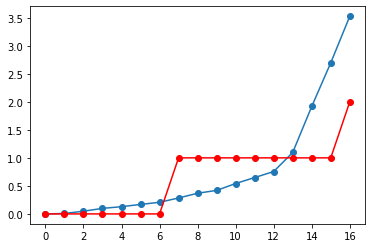

In [16]:
average_plot = []
for i, item in enumerate(averagecount_array):
    average_plot.append(averagecount_array[i] / len(station_names))
print(average_plot)
    
plt.plot(average_plot, '-o')
plt.plot(count_array,'-or')


In [35]:
# for claire: save dataframe as csv
import csv
import collections

        
#ID	user	created_at	text	retweets	station_referral
np.savetxt('clairedata.csv', (tweetsdf['ID'],tweetsdf['created_at'],tweetsdf['text'],tweetsdf['retweets'],tweetsdf['station_referral']), delimiter=',')




TypeError: Mismatch between array dtype ('object') and format specifier ('%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e')

## Data Wrangling
***
We further split our data wrangling into three parts:
1. Wrangling at the Community District level
2. Wrangling at the Transit District level

### Wrangling at the Community District level

In [ ]:
# Code and descriptions, etc.

### Wrangling at the Transit District level

In [ ]:
# More code and descriptions, etc.

## Data Visualization
***
We visualize data and stuff

In [ ]:
# More of code and descriptions, etc.

# Sources:
https://nyc.streetsblog.org/2019/11/14/mta-will-spend-249m-on-new-cops-to-save-200m-on-fare-evasion/ , defining disparate impact
*These are really really not finished*